# Praca domowa nr 4
### Wojciech Celej

---

## 1. Odtworzenie danych

In [97]:
import numpy as np
import pandas as pd
import collections

In [98]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Przygotowanie danych

Wybrane przeze mnie zmienne to:
* ilościowe: 
    - `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    - `w6_q24_length` - length of q24 how met answer in characters 
* jakościowe: 
    - `hcm2017q24_church` - met in or through church or religious organization
    - `hcm2017q24_btwn_I_sig_other` - significant other relationship  between intermediaries

In [99]:
features = ["time_from_rel_to_cohab", "w6_q24_length", "hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", "S1"]

In [100]:
myDf = df.loc[:, features].dropna()
myDf = myDf.query("time_from_rel_to_cohab > 0")

In [101]:
myDf.loc[:,"hcm2017q24_church"] = myDf.loc[:,"hcm2017q24_church"].map({"yes": 1, "no": 0})
myDf.loc[:,"hcm2017q24_btwn_I_sig_other"] = myDf.loc[:,"hcm2017q24_btwn_I_sig_other"].map({"yes": 1, "no": 0})
myDf.loc[:,"S1"] = myDf.loc[:,"S1"].apply(lambda x: 1 if x.startswith("Yes") else 0).astype(np.int32)

In [102]:
myDf.describe()

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other,S1
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,2.062339,200.837784,0.063417,0.015531,0.768335
std,2.775628,253.214722,0.243764,0.123677,0.421987
min,0.083252,1.000000,0.000000,0.000000,0.000000
25%,0.500000,67.000000,0.000000,0.000000,1.000000
50%,1.166748,136.000000,0.000000,0.000000,1.000000
75%,2.583252,241.000000,0.000000,0.000000,1.000000
max,36.750000,3855.000000,1.000000,1.000000,1.000000


### Klasyfikator: LightGBM

In [103]:
import lightgbm
import sklearn.model_selection
import sklearn.metrics

In [104]:
fit_params = {
    "categorical_feature": ["hcm2017q24_church", "hcm2017q24_btwn_I_sig_other"]
}

In [105]:
lightgbm_model = lightgbm.LGBMClassifier()
X = myDf.iloc[:, :4]
y = myDf.loc[:, "S1"]
cv_scores = sklearn.model_selection.cross_validate(lightgbm_model, X, y, cv = 3, fit_params=fit_params)

c:\program files\python37\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hcm2017q24_btwn_I_sig_other', 'hcm2017q24_church']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python37\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hcm2017q24_btwn_I_sig_other', 'hcm2017q24_church']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python37\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['hcm2017q24_btwn_I_sig_other', 'hcm2017q24_church']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [106]:
lightgbm_model.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [107]:
cv_scores["test_score"].mean()

0.7368444277616536

---

## 2. Wygenerowanie N = 1000 próbek z wagami

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
sample = X.sample(n=1, random_state=125).reset_index(drop=True)
sample

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other
0,0.083374,58.0,0,0


In [110]:
explained_features = ["time_from_rel_to_cohab", "w6_q24_length"]

In [111]:
def generate_N_points_with_weights(df, sample, N, pert_features, plot=False):
    assert len(pert_features) == 2, "Give list with length 2"
    x1_sample = sample[pert_features[0]].item()
    x2_sample = sample[pert_features[1]].item()
    new_x1, new_x2 = abs(np.random.multivariate_normal([x1_sample, x2_sample], 0.2*df[[pert_features[0], pert_features[1]]].cov(), N).T)

    std_new_x1 = (new_x1 - new_x1.mean())/new_x1.std()
    std_new_x2 = (new_x2 - new_x2.mean())/new_x2.std()
    std_x1_sample = (x1_sample - new_x1.mean())/new_x1.std()
    std_x2_sample = (x2_sample - new_x2.mean())/new_x2.std()
    
    distances = (std_new_x1 - std_x1_sample)**2 + (std_new_x2 - std_x2_sample)**2
    weights = distances.max() - distances
    weights = weights / weights.sum()
    
    if plot:
        plt.scatter(new_x1, new_x2, c=weights)
        plt.plot(x1_sample, x2_sample, "x", color="firebrick", markersize=10)
        plt.show()
    
    missed_columns = set(df.columns) - set(pert_features)
    Z = pd.DataFrame(columns=df.columns)
    Z[pert_features[0]] = new_x1
    Z[pert_features[1]] = new_x2
    for column in missed_columns:
        Z[column] = np.repeat(sample[column].item(), N)
        
    return Z, weights

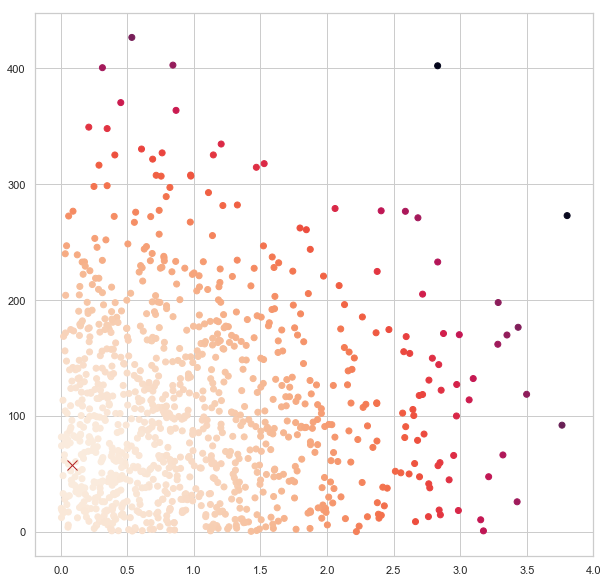

In [112]:
sns.set(rc={'figure.figsize':(10,10)}, style="whitegrid")
Z, weights = generate_N_points_with_weights(X, sample, 1000, explained_features, plot=True)

---

## 3. Predykcja modelu na zbiorze danych Z

In [113]:
z_pred = lightgbm_model.predict(Z)

---

## 4. Dopasowanie modelu białej skrzynki

In [114]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from matplotlib import colors as c
import pydotplus

In [115]:
linear_model = DecisionTreeClassifier(max_depth=3)
linear_model.fit(Z, z_pred, sample_weight=weights)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

---

## 5. Narysowanie modelu, porównanie

In [122]:
def comparise_models(model1, model2, Z, sample, pert_features):
    x_min = Z[pert_features[0]].min()
    x_max = Z[pert_features[0]].max()
    y_min = Z[pert_features[1]].min()
    y_max = Z[pert_features[1]].max()
    
    ym, xm = np.mgrid[y_min:y_max:1, x_min:x_max:0.05]
    zm = np.array([xm, ym])
    zm = zm.swapaxes(0, 2)
    zm = zm.swapaxes(0, 1)
    x_shape = zm.shape[0]
    y_shape = zm.shape[1]
    zm = zm.reshape(x_shape*y_shape, 2)
    
    missed_columns = set(Z.columns) - set(pert_features)
    newZ = pd.DataFrame(columns=Z.columns)
    newZ[pert_features[0]] = zm[:, 0]
    newZ[pert_features[1]] = zm[:, 1]
    for column in missed_columns:
        newZ[column] = np.repeat(sample[column].item(), newZ.shape[0])
        
    fig, axes = plt.subplots(1, 2)

    pred_z1 = model1.predict(newZ).reshape(x_shape, y_shape)
    pred_z2 = model2.predict(newZ).reshape(x_shape, y_shape)
    
    p1 = axes[0].pcolormesh(xm, ym, pred_z1, alpha=0.2, linewidth=0, rasterized=True, cmap=c.ListedColormap(["C1", "C0"]))
    p2 = axes[1].pcolormesh(xm, ym, pred_z2, alpha=0.2, linewidth=0, rasterized=True, cmap=c.ListedColormap(["C1", "C0"]))
    p1.set_edgecolor("face")
    p2.set_edgecolor("face")
    
    sns.scatterplot(data = Z, x = pert_features[0], y = pert_features[1], hue = model1.predict(Z), ax=axes[0], palette =["C1", "C0"])
    sns.scatterplot(data = Z, x = pert_features[0], y = pert_features[1], hue = model2.predict(Z), ax=axes[1], palette =["C1", "C0"])
    axes[0].set_xlim([x_min, x_max])
    axes[0].set_ylim([y_min, y_max])
    axes[1].set_xlim([x_min, x_max])
    axes[1].set_ylim([y_min, y_max])
    axes[0].set_title("Tree model", fontsize = 15)
    axes[1].set_title("Blackbox model", fontsize = 15)
    axes[0].legend("")
    axes[1].legend(title="Married")
    axes[1].set_ylabel("")
    
    plt.show()


### Porównanie modeli w 2D

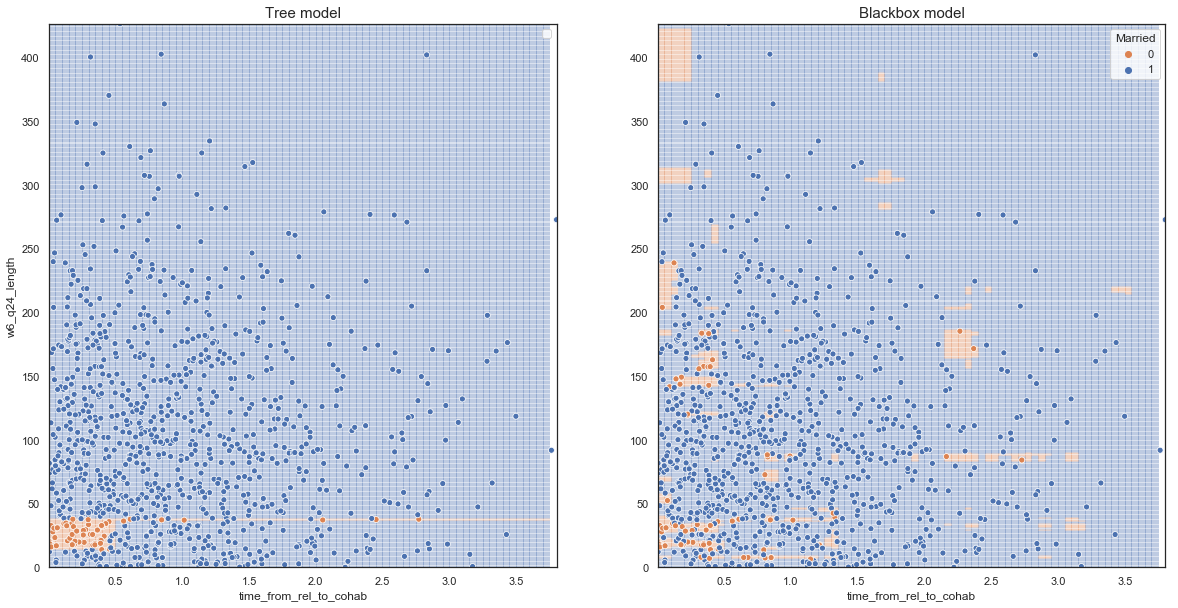

In [123]:
sns.set(rc={'figure.figsize':(20,10)}, style="white")
comparise_models(linear_model, lightgbm_model, Z, sample, explained_features)

### Wyjaśnienie modelu white box

In [118]:
def draw_tree(dtree, df):
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=df.columns,
                    class_names=dtree.classes_.astype(np.str))
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    
    return Image(graph.create_png())

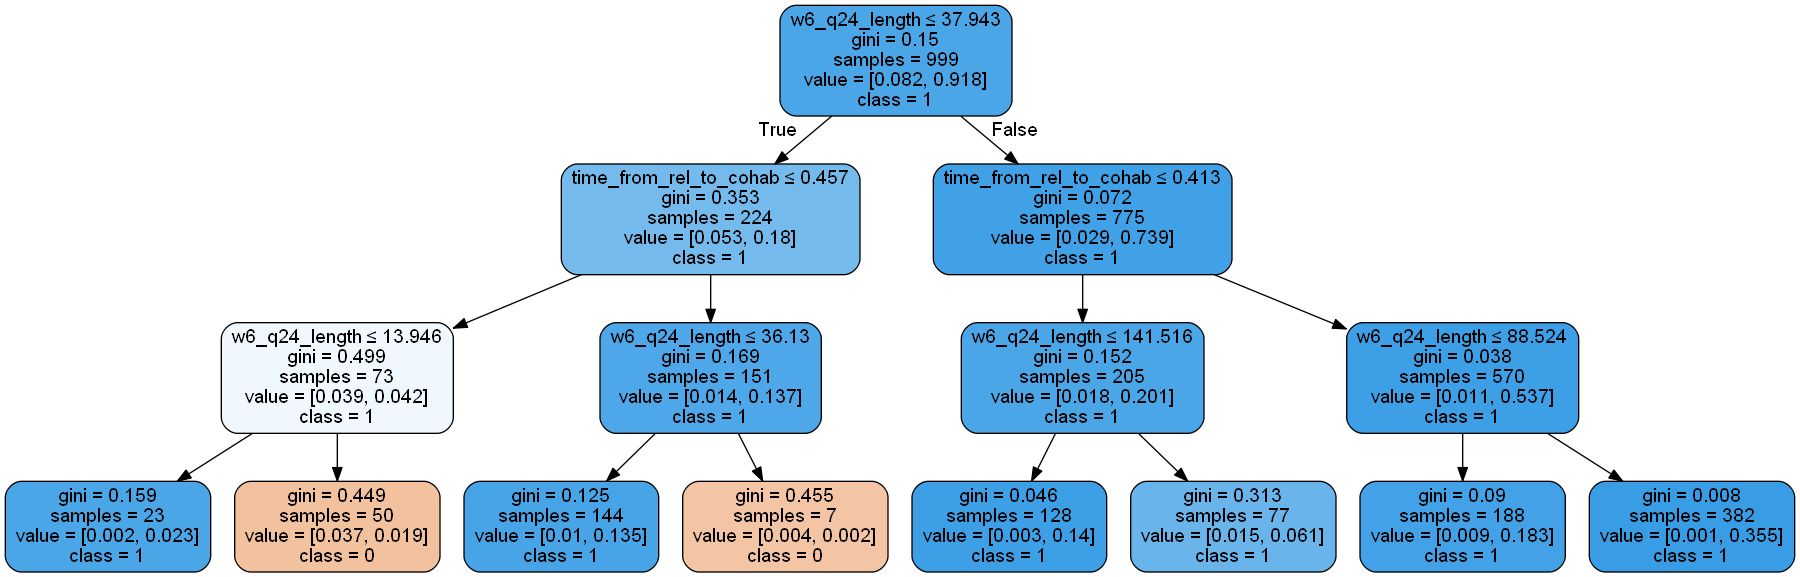

In [119]:
draw_tree(linear_model, Z)

### Porównanie z wykresami Break Down

In [120]:
def plot_break_down(model, df, sample, features_path, ax):
    modDf = df.copy()
    y = model.predict_proba(modDf)[:,1]
    resultDf = pd.DataFrame(data = {"marriedProb": y, "step": "all data"})
    for feature in features_path:
        value_of_feature = sample.loc[0, feature]
        modDf[feature] = value_of_feature
        y = model.predict_proba(modDf)[:,1] 
        resultDf = resultDf.append(pd.DataFrame(data = {"marriedProb": y, "step": "+ {} = {:0.2f}".format(feature, value_of_feature)}), ignore_index=True)
    steps = resultDf["step"].unique()[::-1]
    sns.violinplot(data = resultDf,  x="marriedProb", y="step", inner=None, order=steps, ax=ax, color = "white")
    means = []
    for i, step in enumerate(steps):
        mean = resultDf.loc[resultDf["step"]==step].loc[:, "marriedProb"].mean()
        ax.plot(mean, i, "o", color="firebrick", markersize=10)
        ax.text(mean + 0.025, i - 0.15, "{:0.3f}".format(mean))
        means.append(mean)
    for i in range(len(steps)-2, -1, -1):
        diff = means[i]-means[i+1]
        color = "darkgreen" if diff >= 0 else "darkred"
        ax.text(1.05, i, "{:+0.3f}".format(diff), color = color)
    ax.grid(axis="y")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xlim(0, 1)

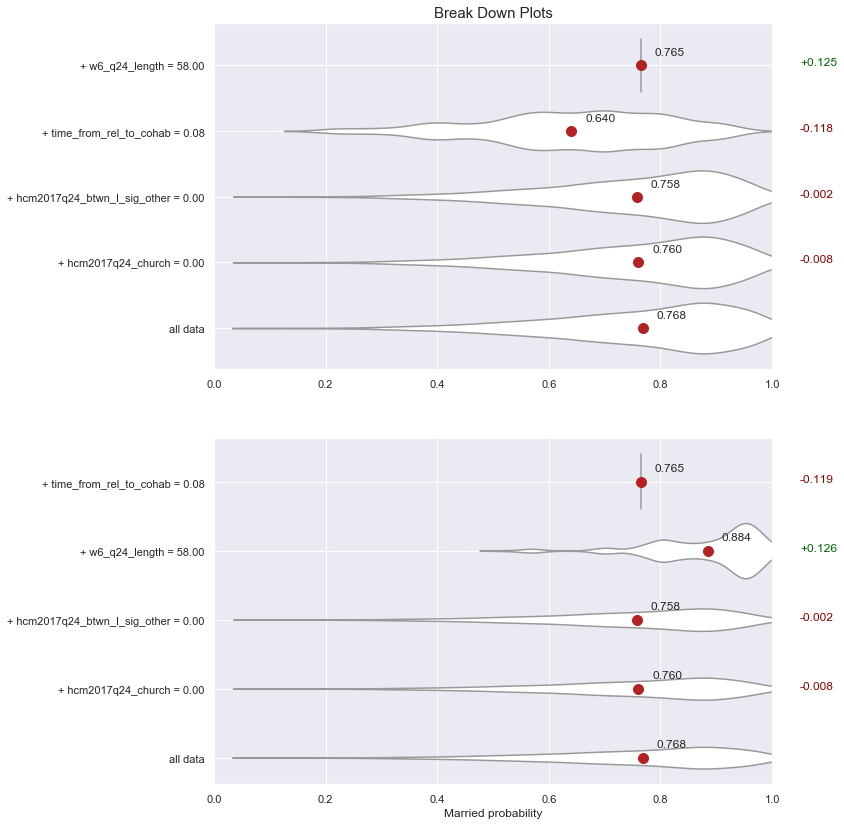

In [121]:
sns.set(rc={'figure.figsize':(10,14)}, style="darkgrid")

fig, axes = plt.subplots(2, 1)
order1 = ["hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", *explained_features]
order2 = ["hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", *explained_features[::-1]]

plot_break_down(lightgbm_model, X, sample, order1, axes[0])
plot_break_down(lightgbm_model, X, sample, order2, axes[1])

axes[0].set_title("Break Down Plots", fontsize = 15)
axes[1].set_xlabel("Married probability")
plt.show()

### Wyjaśnienie

In [124]:
sample

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other
0,0.083374,58.0,0,0


1. Punkty generowano z 2-wymiarowego rozkładu normalnego wycentrowanego w próbce, o macierzy kowariancji równej 0.2 macierzy kowariancji wyliczonej na oryginalnym zbiorze. Na wygenerowanych punktach policzono moduł, ponieważ obie wielkości mają sens jedynie wtedy, gdy są nieujemne.
1. Do policzenia wag użyto odległość kartezjańską w ustandaryzowanej przestrzeni parametrów. Od największej odległości odjęto pozostałe odległości, a otrzymany wektor podzielono przez sumę jego współrzędnych. W ten sposób otrzymano wektor wag.
1. Modelem *black box* został model boostingowy LightGBM.
1. Jako model *white box* wybrano model drzewa decyzyjnego o maksymalnej głębokości równej 3. Dokonuje ono przyporządkowania do klasy 0 gdy ` 13.946 < w6_q24_length < 37.943` a `time_from_rel_to_cohab < 0.457`. Odpowiada to pomarańczowemu prostokątowi w lewym dolnym rogu na predykcji dla drzewa. 
1. Próbka przyjmuje dla zmiennej `time_from_rel_to_cohab` wartość 0.083 (co obniża w obu scenariuszach break down prawdopodobieństwo przynależenia do klasy 1 o ponad 0.1). Jest to wartość dla której istnieje szansa trafienia do klasy 0, co widać na wytrenowanym drzewie.
1. Zmienna `w6_q24_length` w obu scenariuszach break down zwiększa prawdopodobieństwo przynależenia do klasy 1 o ponad 0.12. Jest to zgodne z predykcją dla drzewa. Dla tej wartości drzewo odrzuci klasę 0 już w najwyższym wierzchołku.
1. Wyjaśnienia uzyskane metodą lokalną i break down są spójne.
